<a href="https://colab.research.google.com/github/anshudaur/TensorFlowProjects/blob/master/CVDL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
# data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#                                          fname='flower_photos', untar=True)
# # print(data_dir)
# data_dir = pathlib.Path(data_dir)
# print(data_dir)

In [0]:
data_dir=pathlib.Path('train')
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

4918

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [0]:
import numpy as np
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
# print(CLASS_NAMES)

In [0]:
# train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
#                                                      batch_size=BATCH_SIZE,
#                                                      shuffle=True,
#                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                      classes = list(CLASS_NAMES))

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
# image_batch, label_batch = next(train_data_gen)
# show_batch(image_batch, label_batch)

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# print(labeled_ds)

In [0]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
#   print("Label: ", label.numpy())

Image shape:  (224, 224, 3)


In [0]:


def prepare_for_training(ds, cache=True, shuffle_buffer_size=6000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
# image_batch, label_batch = next(iter(labeled_ds))
# data = tf.data.Dataset.from_tensor_slices(
#     (image_batch.reshape(image_batch.shape[0],224,224,3).astype(np.float32) / 255, label_batch.astype(np.int32)))
# data = data.shuffle(buffer_size=60000).batch(128).repeat()

train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

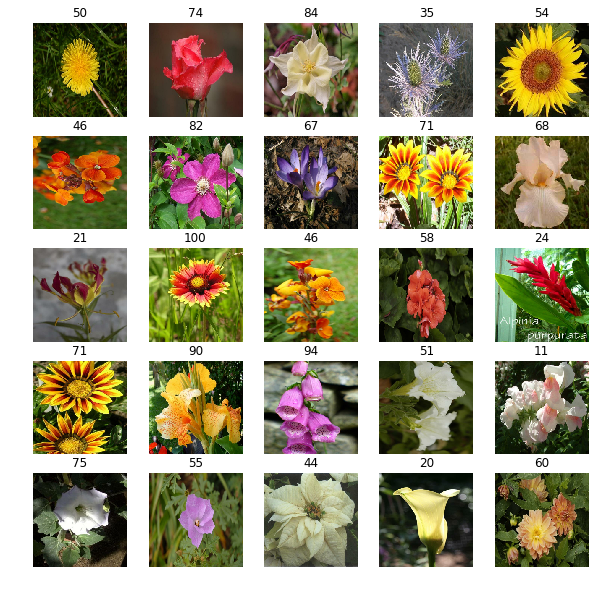

In [0]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
from tensorflow.keras import datasets, layers, models
layer_list = [layers.Conv2D(128, (3, 3), activation='tanh', input_shape=(224, 224, 3)),
              layers.Conv2D(128, (3, 3), activation='tanh'),
              layers.Conv2D(256, (3, 3), activation='tanh'),layers.Conv2D(256, (3, 3), activation='tanh'),
              layers.Flatten(),layers.Dense(102)]

model = tf.keras.Sequential(layer_list)



opt = tf.keras.optimizers.Adam()
# from_logits = True!! #neverforget
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()


In [0]:
model.compile(optimizer=opt, loss=loss_fn, metrics=[train_acc_metric])

In [0]:
model.fit(image_batch, steps_per_epoch=1000, epochs=2)